# License Plate Recognition

@misc{
license-plate-recognition-rxg4e_dataset,
title = { License Plate Recognition Dataset },
type = { Open Source Dataset },
author = { Roboflow Universe Projects },
howpublished = { \url{ https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e } },
url = { https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e },
journal = { Roboflow Universe },
publisher = { Roboflow },
year = { 2024 },
month = { oct },
note = { visited on 2025-02-17 },
}

* References
    1. https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb
    2. https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#evaluating-the-model-optional

## Imports

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.15.1')

In [4]:
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mlflow
from tqdm.notebook import tqdm
import random
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
%matplotlib inline
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

In [7]:
from utils.visualization_funcs import plot_random_images_bbox
from utils.annotation_processor import AnnotationProcessor

## Paths Setup

In [8]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/License-Plate-Recognition-8/train/


In [9]:
cfg.OUTPUTS

{'OUPUT_DIR': 'exported_models/my_${PRETRAIN_MODEL.MODEL_NAME}', 'EXPORTER_SCRIPT': '/opt/models/research/object_detection/exporter_main_v2.py', 'CONFIG_PIPELINE_PATH': '${OUTPUTS.OUPUT_DIR}/', 'CHECKPOINT_PATH': '${OUTPUTS.OUPUT_DIR}/checkpoints/'}

In [10]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
DATASET_DIRS.mkdir(parents=True, exist_ok=True)

TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

TRAIN_ANNOT_FILE_PATH = TRAIN_DIR / cfg.DATASET.ANNOTATION_FILE_NAME
TEST_ANNOT_FILE_PATH = TEST_DIR / cfg.DATASET.ANNOTATION_FILE_NAME
VALID_ANNOT_FILE_PATH = VALIDATION_DIR / cfg.DATASET.ANNOTATION_FILE_NAME

CONFIG_PIPELINE_PATH = Path(cfg.OUTPUTS.CONFIG_PIPELINE_PATH)
PRETRAIN_MODEL_PATH  = Path(cfg.PRETRAIN_MODEL.PATH)



In [11]:
TRAIN_DIR

PosixPath('datasets/License-Plate-Recognition-8/train')

## Plot util functions

In [12]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    is_save=False,
                    image_name=None,
                    groundtruth_box_visualization_color=None):
    """Wrapper function to visualize detections.
      https://github.com/tensorflow/models/blob/bf8b76eafd180c4657d3990a8fad0975ce1ed722/research/object_detection/utils/visualization_utils.py#L1102
    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    img = viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.7,
      line_thickness=3,
      groundtruth_box_visualization_color=groundtruth_box_visualization_color)

    return img

#     if is_save:
#         plt.imsave(image_name, image_np_with_annotations)

#     else:
#         plt.title(image_name)
#         plt.imshow(image_np_with_annotations)

## Load Test images from directory

In [13]:
label_map = {
    'License_Plate':1
}

prepare_test_dataset = AnnotationProcessor(annotation_file=TEST_ANNOT_FILE_PATH)

test_images, test_class_ids, test_bboxes  = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, label_map=label_map)

len(test_images), len(test_class_ids), len(test_bboxes)

(15, 15, 15)

In [14]:
## Load test images and run inference with new model!
prepared_test_images = []
# test_images, test_class_ids, test_bboxes 
for img in test_images:
    img = cv2.resize(img, dsize=(640,640))
    # prepared_test_images.append(np.expand_dims(img, axis=0))
    prepared_test_images.append(img)

len(prepared_test_images)

15

### Define the category index dictionary

In [15]:
# Assign the license plate class ID
class_id = 1

# define a dictionary describing license plate class
category_index = {class_id :
{'id'  : class_id,
 'name': 'License_Plate'}
}

# Specify the number of classes that the model will predict
num_classes = 1
print(category_index[class_id])

{'id': 1, 'name': 'License_Plate'}


## Loading saved model

In [16]:
OUTPUTS_DIRS = Path(cfg.OUTPUTS.OUPUT_DIR)
EXPORTER_SCRIPT = Path(cfg.OUTPUTS.EXPORTER_SCRIPT)

CHECKPOINT_PATH = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)
CHECKPOINT_PATH

PosixPath('exported_models/my_ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoints')

### Initializing model with random shape

In [17]:
# Load the exported model
loaded_model = tf.saved_model.load(f'{OUTPUTS_DIRS}')

# Perform inference
input_tensor = tf.random.uniform([1, 640, 640, 3])  # Example input tensor
loaded_mdl_detections = loaded_model.signatures["serving_default"](input_tensor)

## Run Inference

In [18]:
total_test_images = len(test_images)

In [19]:
prepared_test_images[0].shape

(640, 640, 3)

In [20]:
np.expand_dims(prepared_test_images[0], axis=0).shape

(1, 640, 640, 3)

In [21]:
category_index

{1: {'id': 1, 'name': 'License_Plate'}}

In [22]:
test_bboxes[0]

array([[0.35069444, 0.203125  , 0.37847222, 0.26367188],
       [0.27256944, 0.37890625, 0.28125   , 0.3984375 ],
       [0.46701389, 0.71191406, 0.55555556, 0.7578125 ]])

rand_indx=3


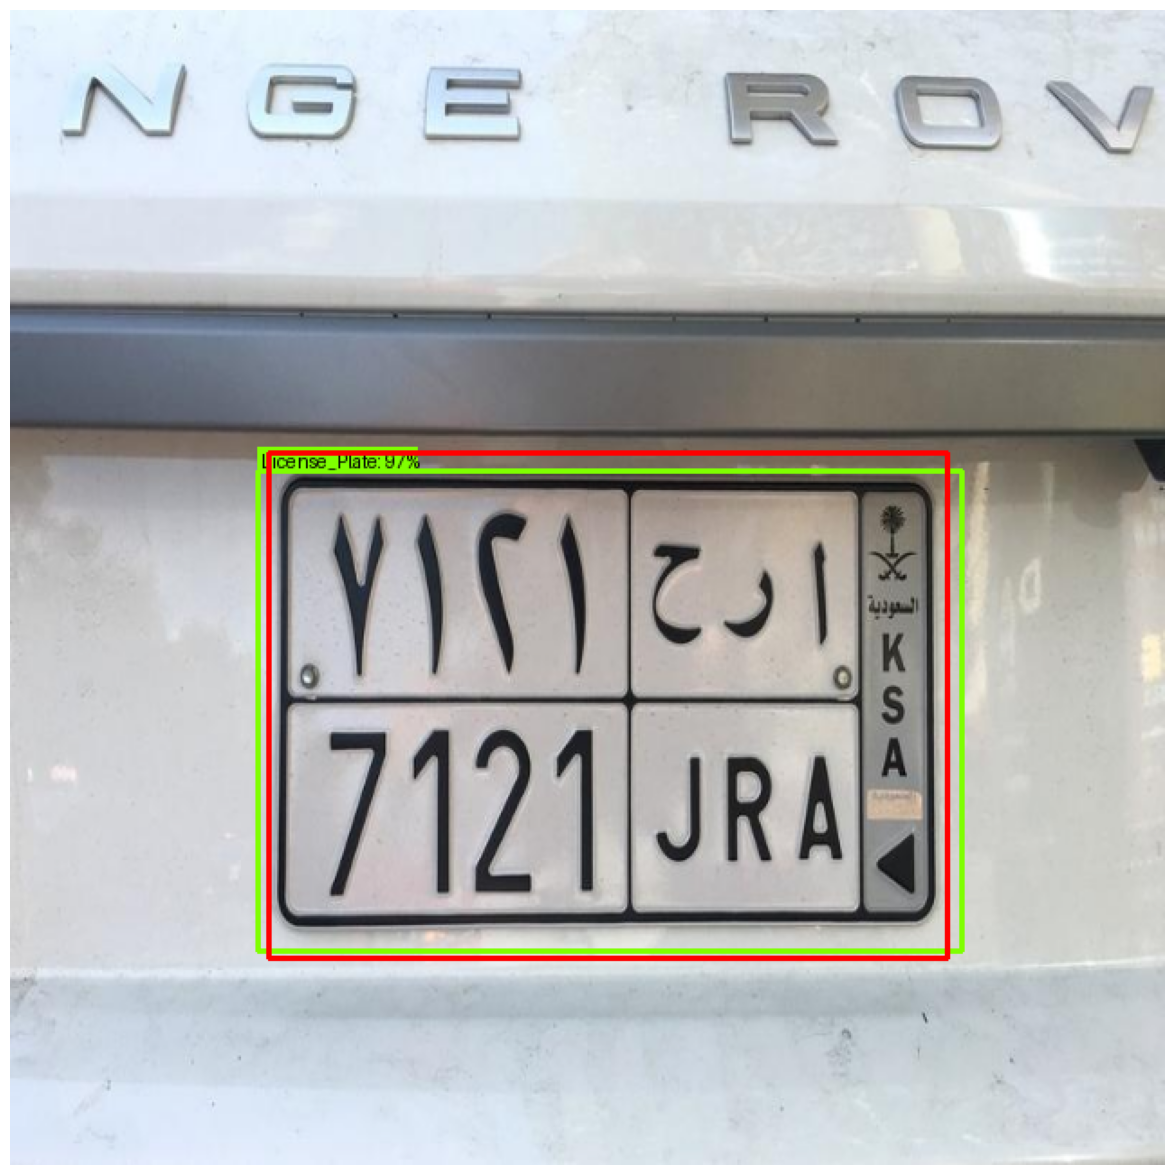

In [23]:
rand_indx = random.randint(0, total_test_images)
print(f'{rand_indx=}')
random_img = prepared_test_images[rand_indx]

# plt.figure(figsize=(15, 15))
input_tensor = tf.convert_to_tensor(np.expand_dims(random_img, axis=0), dtype=tf.float32)
_detections = loaded_model.signatures["serving_default"](input_tensor)
box_img = plot_detections(
  image_np=random_img,
  boxes=_detections['detection_boxes'][0].numpy(),
  classes=_detections['detection_classes'][0].numpy().astype(np.uint32) + 1,
  scores=_detections['detection_scores'][0].numpy(),
  category_index=category_index, figsize=(15, 20))

#

plt.figure(figsize=(15, 15))
dummy_scores = np.array([1.0], dtype=np.float32)
# input_tensor = tf.convert_to_tensor(np.expand_dims(random_img, axis=0), dtype=tf.float32)
# _detections = loaded_model.signatures["serving_default"](input_tensor)
final_img = plot_detections(
  image_np=box_img,
  boxes=test_bboxes[rand_indx],
  classes=test_class_ids[rand_indx],
  scores=None,
  category_index=category_index, 
  figsize=(15, 20),
  groundtruth_box_visualization_color='Red'
  )

plt.imshow(final_img)
plt.axis('off')
plt.show()

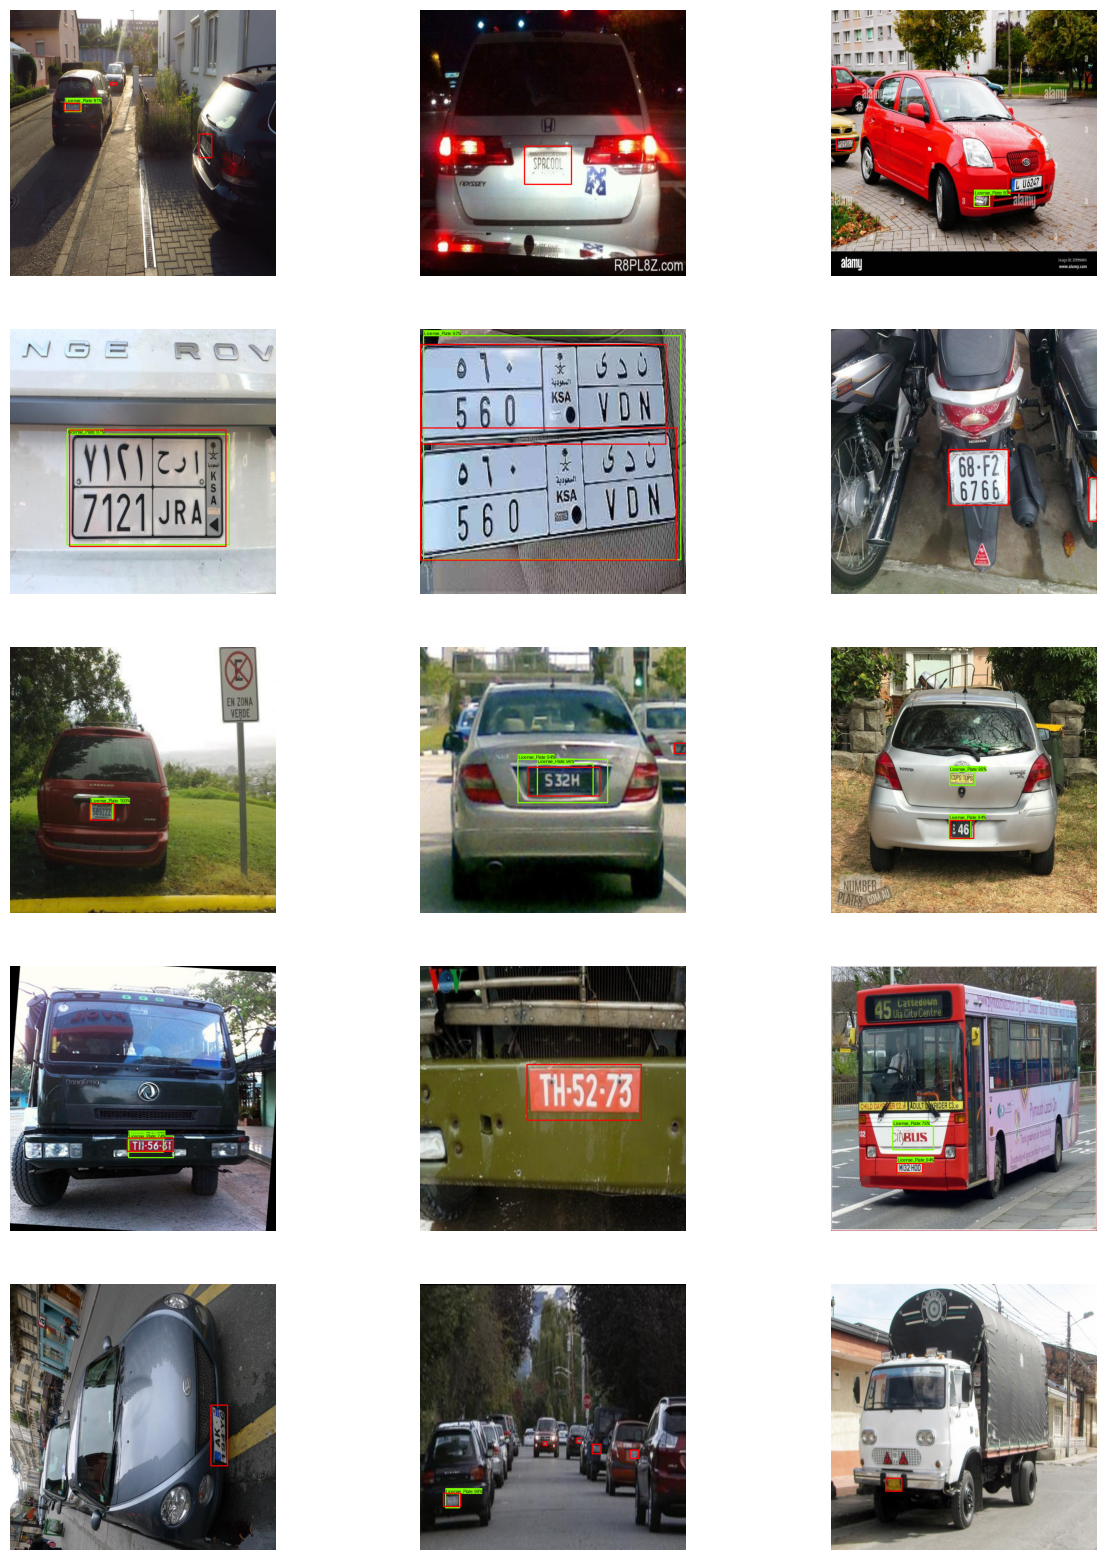

In [32]:
plt.figure(figsize=(15, 20))
label_id_offset = 1
for i in range(total_test_images):
    plt.subplot(5, 3, i+1)
    img = np.expand_dims(prepared_test_images[i], axis=0)
    input_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    _detections = loaded_model.signatures["serving_default"](input_tensor)

    box_img = plot_detections(
      image_np=prepared_test_images[i],
      boxes=_detections['detection_boxes'][0].numpy(),
      classes=_detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
      scores=_detections['detection_scores'][0].numpy(),
      category_index=category_index, 
      # figsize=(15, 20)
      )
    
    final_img = plot_detections(
    image_np=box_img,
    boxes=test_bboxes[i],
    classes=test_class_ids[i],
    scores=None,
    category_index=category_index, 
    # figsize=(15, 20),
    groundtruth_box_visualization_color='Red'
    )

    plt.imshow(final_img)
    plt.axis('off')
plt.show()